In [1]:
import matplotlib.pyplot as plt
import numpy as np
from utils import reshape_data, get_dataset, get_dataloader, SeismicDataset
import torch
from torchvision import transforms

In [2]:
get_dataset()

Dataset already downloaded!


In [3]:
data_path = 'data/dataset.npy'
number_degradations = 12
reshape_data(data_path, number_degradations)

Data already reshaped!


In [ ]:
dataset = np.load(f'data/dataset_reshaped.npy', allow_pickle=True)
print(dataset.shape); print(len(dataset))

In [ ]:
idx = 0
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(dataset[idx][0], cmap='seismic')
ax[1].imshow(dataset[idx][1], cmap='seismic')
plt.show()


In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = SeismicDataset(data_path='data/dataset_reshaped.npy', transform=transform)

In [ ]:
dataset.__len__()
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(dataset[0][0].squeeze(), cmap='seismic')
ax[1].imshow(dataset[0][1].squeeze(), cmap='seismic')

In [4]:
trainloader, valoader, testloader = get_dataloader(batch_size=32, num_workers=4, data_path='data/dataset_reshaped.npy')

In [5]:
len(trainloader), len(valoader), len(testloader)

(300, 38, 38)

In [8]:
img, degr = next(iter(trainloader))

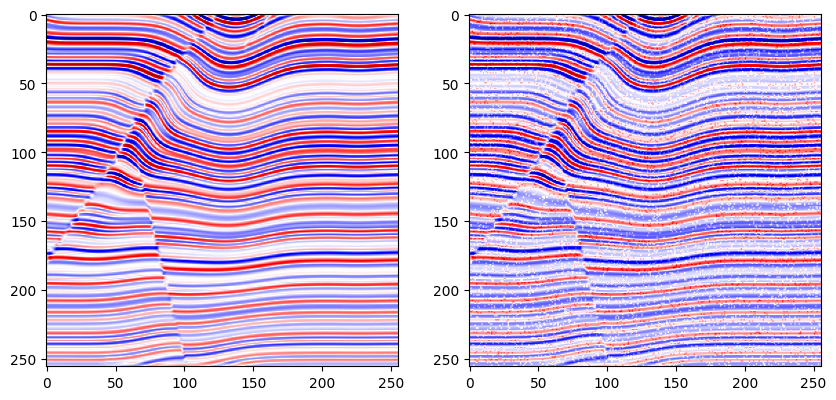

In [9]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(img[0].squeeze(), cmap='seismic')
ax[1].imshow(degr[0].squeeze(), cmap='seismic')